In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
DATASET_PATH = '/content/gdrive/MyDrive/RealEstate/sem_4/Train_Cluster_Check/gmm_clustered_tags_70.npy'

In [3]:
!pip -q install -U sentence-transformers &>/dev/null

In [4]:
import json
import requests
import re
import os
import matplotlib.pyplot as plt
import pickle
import string
import functools
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from tqdm import tqdm_notebook
import gc
from pymystem3 import Mystem
from collections import Counter

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# https://www.sbert.net/docs/pretrained_models.html
# from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
!pip list | grep transformers

sentence-transformers         1.0.4         
transformers                  4.5.0         


* `dist` - административный район - нужно проверить пропуски
* `addr` - адрес, есть много пропусков
* `city` - город
* `tags_parsed` - теги для обучения

### Convert to Pandas

In [6]:
dataset = np.load(file=DATASET_PATH,
                  allow_pickle=True)

In [7]:
content, tags = dataset[:, 0], dataset[:, 1]

In [8]:
SEED = 42
df = pd.DataFrame()
df['content'] = content
df['target'] = tags

In [9]:
df.target.nunique()

12

```python
>>> le = preprocessing.LabelEncoder()
>>> le.fit(["paris", "paris", "tokyo", "amsterdam"])
LabelEncoder()
>>> list(le.classes_)
['amsterdam', 'paris', 'tokyo']
>>> le.transform(["tokyo", "tokyo", "paris"])
array([2, 2, 1]...)
>>> list(le.inverse_transform([2, 2, 1]))
['tokyo', 'tokyo', 'paris']
```

In [10]:
le = LabelEncoder()
le.fit(df.target.unique())
encoded_target = le.transform(df.target)
df['target'] = encoded_target

### Setup CUDA

In [11]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P4


### Download model

In [12]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

In [13]:
model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence", return_dict=False)
model = model.to(device)
# embedder.cuda()

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

In [14]:
class SocialDataset(Dataset):
    def __init__(self, df, max_len=160):
        self.content = df.content.to_list()
        self.target = df.target.to_list()
        self.max_len = max_len

    def __len__(self):
        return len(self.content)

    def tokenize(self, queries=None):
        self.encoded_input = tokenizer(self.content,
                                        return_token_type_ids=False,
                                        pad_to_max_length=True,
                                        return_attention_mask=True,
                                        return_tensors='pt',
                                        truncation=True,
                                        max_length=self.max_len)
        return self

    def __getitem__(self, item):
        target = self.target[item]
        txt = str(self.content[item])
        return {
            'content_text': txt,
            'input_ids': self.encoded_input['input_ids'][item].flatten(),  # important to flatten [1, max_length] --> [max_length]
            'attention_mask': self.encoded_input['attention_mask'][item].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

    def create_data_loader(self, batch_size=16):
        self.data_loader = DataLoader(self,
                                        batch_size=batch_size,
                                        num_workers=4)
        return self.data_loader

In [15]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=SEED)
df_train.shape, df_val.shape, df_test.shape

train_data_loader = SocialDataset(df_train).tokenize().create_data_loader()
val_data_loader = SocialDataset(df_val).tokenize().create_data_loader()
test_data_loader = SocialDataset(df_test).tokenize().create_data_loader()

In [16]:
from transformers import PreTrainedModel, BertConfig

class Classifier(PreTrainedModel):

    def __init__(self, config, n_classes):
        super().__init__(config)
        self.bert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence", return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids,
                                attention_mask=attention_mask,
                                return_dict=False)
        output = self.drop(pooled_output)
        return self.out(output)

In [17]:
model = Classifier(config=BertConfig.from_pretrained("DeepPavlov/rubert-base-cased-sentence"),
                   n_classes=len(df.target.unique()))
model = model.to(device)

https://github.com/huggingface/transformers/issues/8879

https://huggingface.co/transformers/migration.html

In [18]:
from transformers import get_linear_schedule_with_warmup, AdamW

n_epochs = 10

# 1
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)  # source

# optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4, correct_bias=False)

total_steps = len(train_data_loader) * n_epochs

scheduler = get_linear_schedule_with_warmup(
                                            optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps
                                            )

loss_eval = nn.CrossEntropyLoss().to(device)

### F1

In [19]:
def train_epoch(model, data_loader, loss_eval, optimizer, scheduler, n_examples):
    model = model.train()
    losses = []
    # ACCURACY
    # correct_predictions = 0
    # F1
    f1 = 0.    
    for d in tqdm_notebook(data_loader):
        # SET DEVICES
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        # NO RETURN DICT REQUIRED (it's in the `forward` method above)
        outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_eval(outputs, targets)

        # ACCURACY
        # correct_predictions += torch.sum(preds == targets)
        # F1
        f1 += f1_score(preds.cpu(), targets.cpu(), average='micro')
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    # ACCURACY
    # return correct_predictions.double() / n_examples, np.mean(losses)
    # F1
    return f1 / len(data_loader), np.mean(losses)

In [20]:
def eval_model(model, data_loader, loss_eval, n_examples):
    model = model.eval()

    losses = []
    # ACCURACY
    # correct_predictions = 0
    # F1
    f1 = 0. 

    with torch.no_grad():
        for d in data_loader:
            # SET DEVICES
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # NO RETURN DICT REQUIRED (it's in the `forward` method above)
            outputs = model(
                            input_ids=input_ids,
                            attention_mask=attention_mask
                            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_eval(outputs, targets)

            # ACCURACY
            # correct_predictions += torch.sum(preds == targets)
            # F1
            f1 += f1_score(preds.cpu(), targets.cpu(), average='micro')
            losses.append(loss.item())
    
    
    # ACCURACY
    # return correct_predictions.double() / n_examples, np.mean(losses)
    # F1
    return f1 / len(data_loader), np.mean(losses)

In [21]:
from sklearn.metrics import f1_score

In [22]:
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

for epoch in range(n_epochs):

    print(f'Epoch: {epoch + 1}')
    print('-' * 10)

    # TRAIN
    train_acc, train_loss = train_epoch(
                                        model,
                                        train_data_loader,    
                                        loss_eval, 
                                        optimizer, 
                                        scheduler, 
                                        len(df_train)
                                        )
    
    gc.collect()
    torch.cuda.empty_cache()
    print(f'Train loss: {round(train_loss, 3)} and accuracy {round(train_acc.item(), 3)}\n')
    # -----------------------------------------------------
    # EVAL
    val_acc, val_loss = eval_model(
                                    model,
                                    val_data_loader,
                                    loss_eval, 
                                    len(df_val)
                                    )

    gc.collect()
    torch.cuda.empty_cache()
    print(f'Val loss: {round(val_loss, 3)} and accuracy {round(val_acc.item(), 3)}\n')
    # ------------------------------------------------------
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        best_accuracy = val_acc

Epoch: 1
----------



Train loss: 0.588 and accuracy 0.796

Val loss: 0.512 and accuracy 0.806

Epoch: 2
----------



Train loss: 0.243 and accuracy 0.918

Val loss: 0.565 and accuracy 0.829

Epoch: 3
----------



Train loss: 0.127 and accuracy 0.961

Val loss: 0.757 and accuracy 0.837

Epoch: 4
----------



Train loss: 0.078 and accuracy 0.977

Val loss: 0.937 and accuracy 0.839

Epoch: 5
----------



Train loss: 0.055 and accuracy 0.986

Val loss: 1.147 and accuracy 0.824

Epoch: 6
----------



Train loss: 0.03 and accuracy 0.993

Val loss: 1.293 and accuracy 0.818

Epoch: 7
----------



Train loss: 0.023 and accuracy 0.995

Val loss: 1.277 and accuracy 0.837

Epoch: 8
----------



Train loss: 0.013 and accuracy 0.997

Val loss: 1.224 and accuracy 0.844

Epoch: 9
----------



Train loss: 0.007 and accuracy 0.998

Val loss: 1.286 and accuracy 0.835

Epoch: 10
----------



Train loss: 0.002 and accuracy 0.999

Val loss: 1.298 and accuracy 0.84



### Show training results

In [23]:
def show_train_results(train_history, val_history, img_name='graph'):
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(train_history, label='train f1')
    ax.plot(val_history, label='val f1')
    ax.set_title('Training F1-score')
    ax.set_xlabel('Epoch number')
    ax.set_ylabel('F1-score')
    ax.legend(loc='best')
    ax.set_ylim([0, 1.1]);
    plt.savefig(img_name, dpi=300)

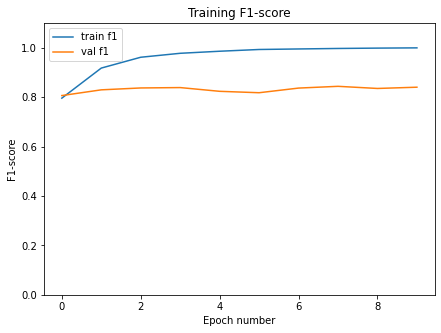

In [24]:
show_train_results(history['train_acc'], history['val_acc'],
                   '/content/gdrive/MyDrive/RealEstate/sem_4/Train_Cluster_Check/new_tags_70')

### Inference

In [25]:
test_acc, _ = eval_model(
                        model,
                        test_data_loader,
                        loss_eval,
                        len(df_test)
                        )

In [26]:
print(f'Test F1: {round(test_acc.item(), 3)}')

Test F1: 0.866
